# Figure - kz series

In [1]:
import os
work_dir = "H:/workspace/ptyrad_paper"
os.chdir(work_dir)
print("Current working dir: ", os.getcwd())

Current working dir:  H:\workspace\ptyrad_paper


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ptyrad.load import load_hdf5
from ptyrad.utils.image_proc import center_crop
import h5py
from skimage.transform import rotate

In [3]:
crop_height, crop_width = (365,365)
kz_weights = [0, 0.01, 0.1, 0.5, 1]

ptyshv_objects = []
angle = 69.5+90

for i, weight in enumerate(kz_weights):
    if weight == 0:
        gt_path  =  "00_data/simu_tBL_WSe2/phonon_temporal_spatial_N16384_dp128.hdf5"
        gt_phase = center_crop(load_hdf5(gt_path, key = 'gt_phase').sum(0), crop_height, crop_width, offset = [1,1])
        gt_phase = rotate(gt_phase, angle)
        ptyshv_objects.append(gt_phase)
    else:
        path_ptyshv   = f"03_output/simu_tBL_WSe2/20250219_ptyshv_convergence/6/roi6_Ndp128_step128/MLs_L1_p12_g16_pc1_noModel_mm_Ns6_dz2_reg{weight}/Niter200.mat"
        with h5py.File(path_ptyshv, "r") as hdf_file:
            obj_ptyshv = center_crop(np.angle(np.array(hdf_file['object']).view('complex128')).sum(0).T, crop_height, crop_width, offset = [-1,-1])
        obj_ptyshv = rotate(obj_ptyshv, angle)
        ptyshv_objects.append(obj_ptyshv)

Success! Loaded .hdf5 file with key = 'gt_phase' from path = '00_data/simu_tBL_WSe2/phonon_temporal_spatial_N16384_dp128.hdf5'
Imported .hdf5 data shape = (15, 369, 368)
Imported .hdf5 data type = float32


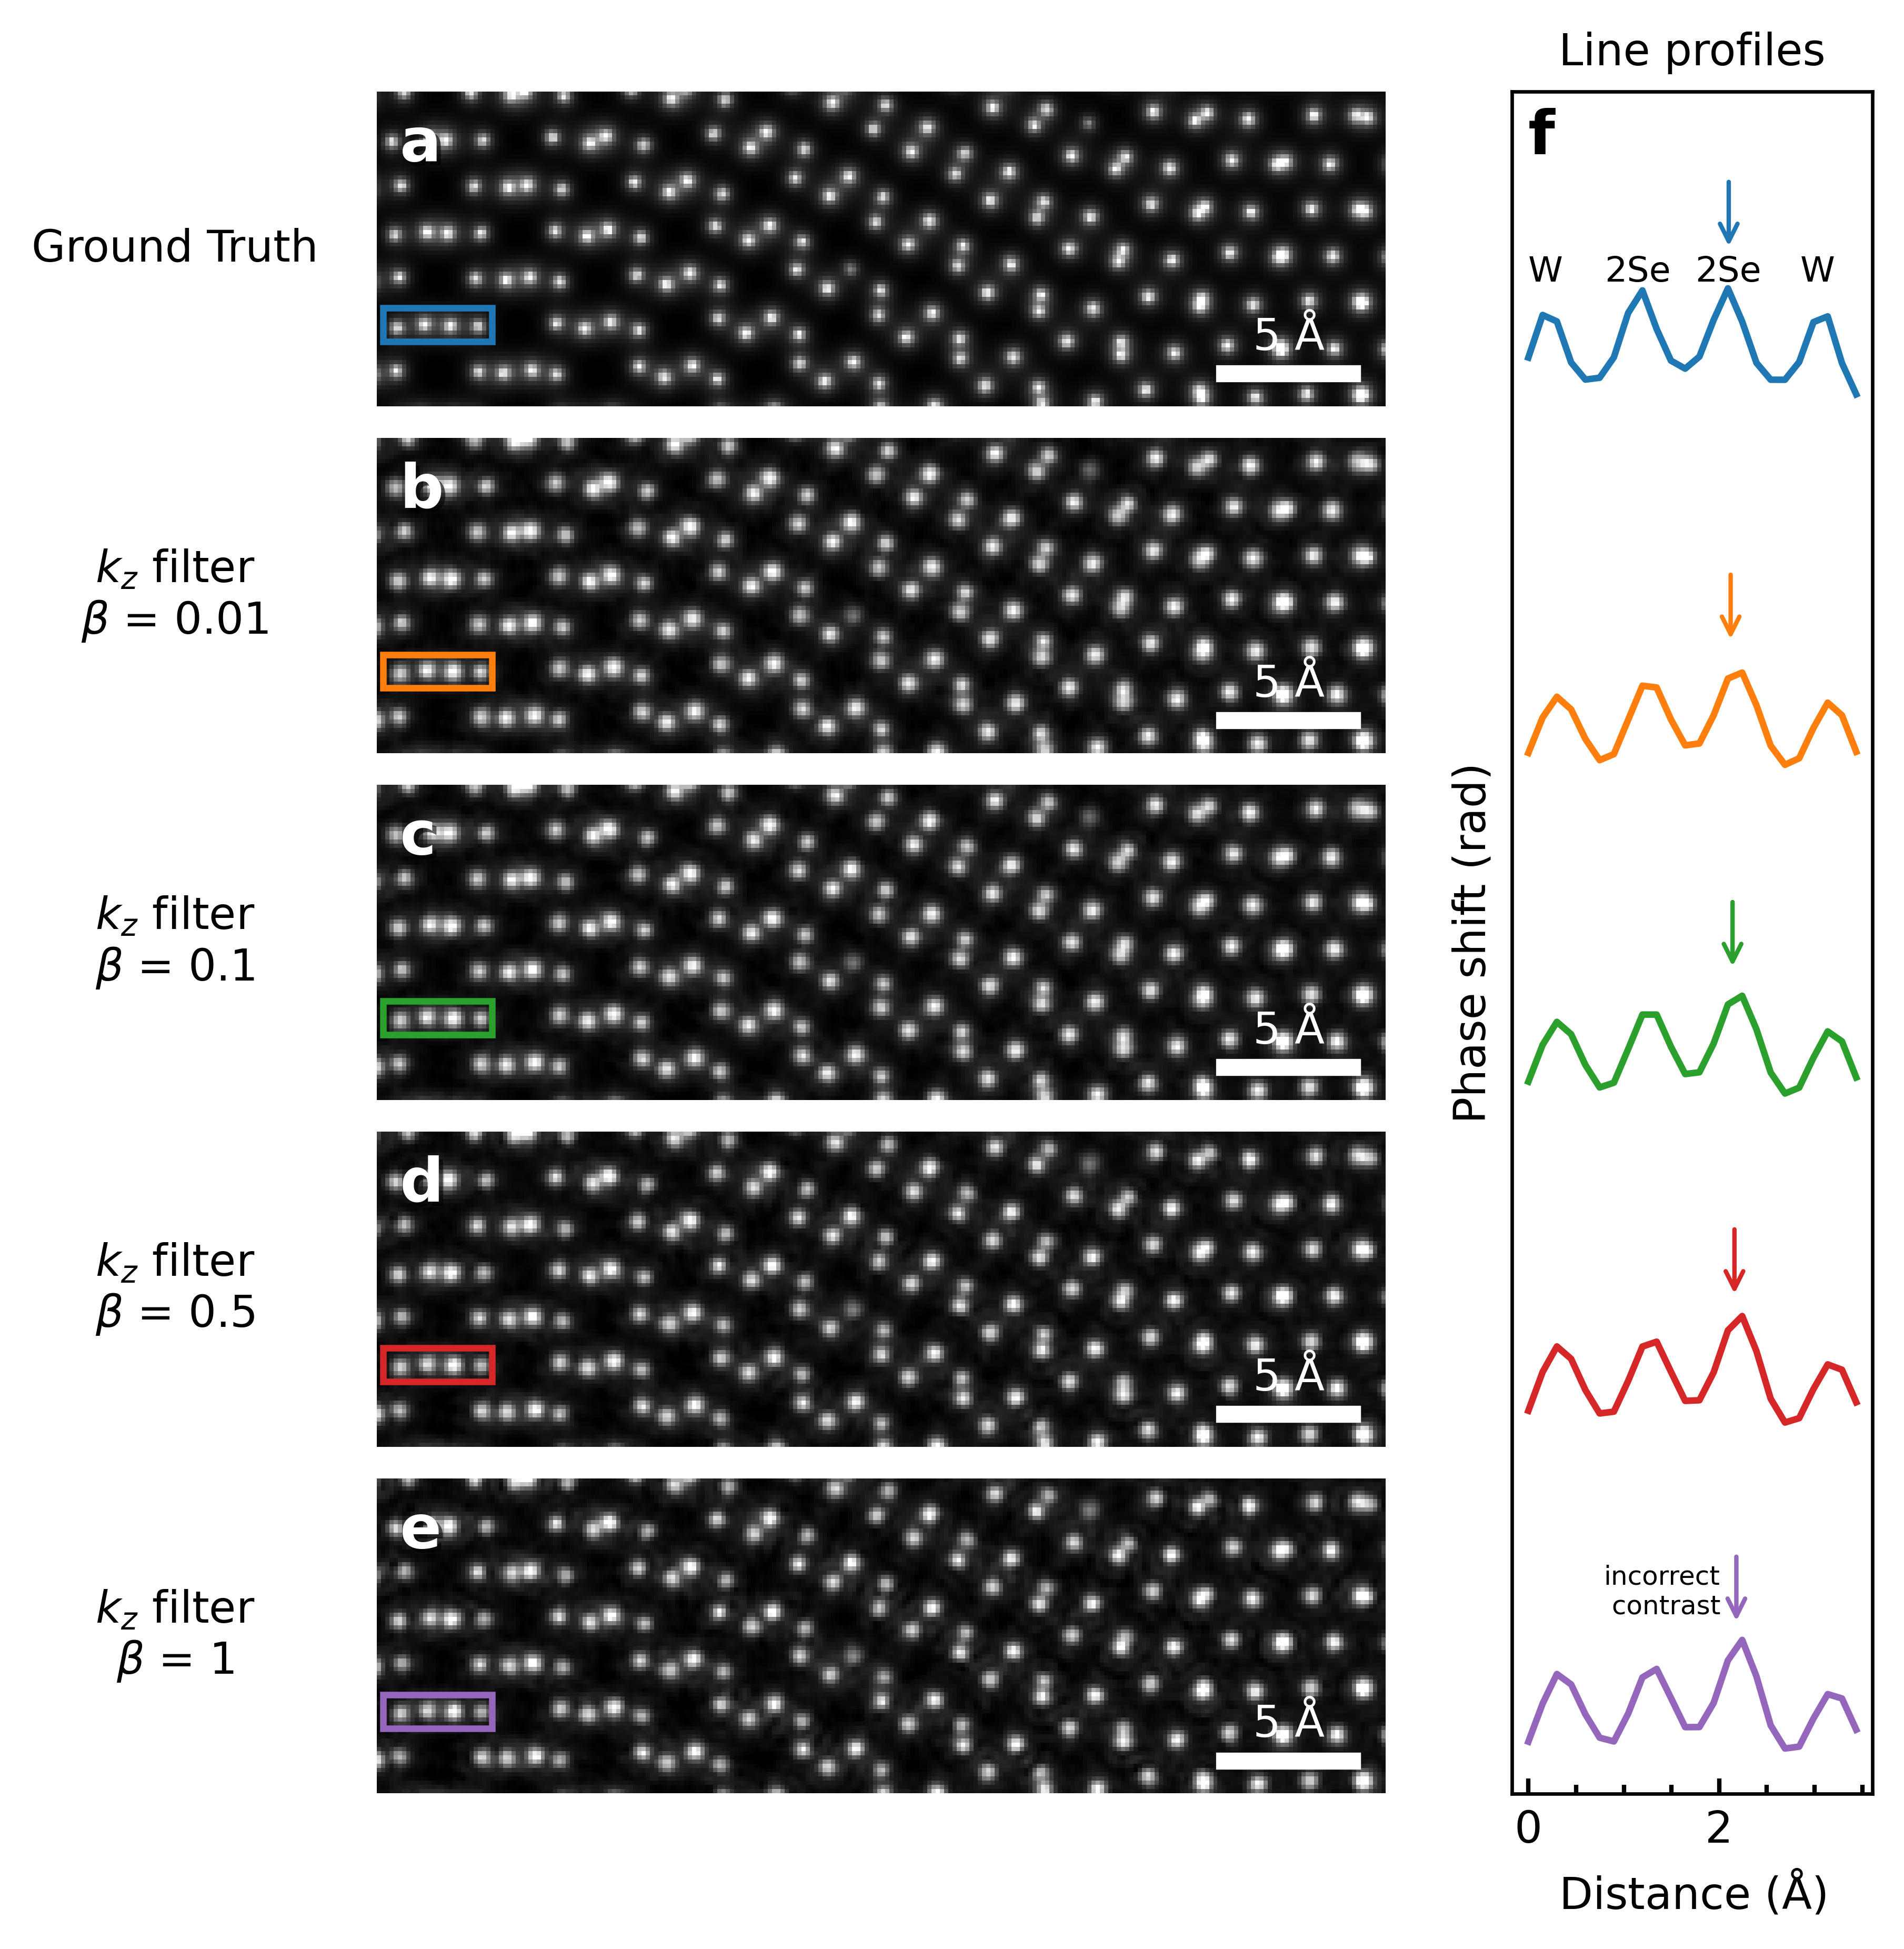

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as tck
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

mpl.rc('xtick', direction='in')
mpl.rc('xtick.major', width=1, size=3.5)
mpl.rc('xtick.minor', width=1, size=2)
mpl.rc('ytick', direction='in')
mpl.rc('ytick.major', width=1, size=3.5)
mpl.rc('ytick.minor', width=1, size=2)

# Create figure and gridspec
fig = plt.figure(figsize=(7, 7), dpi=600)
gs = gridspec.GridSpec(5, 2, width_ratios=[4, 1], wspace=-0.1, hspace=0.1)

# Panel labels
panel_labels = ['a', 'b', 'c', 'd', 'e', 'f']
shadow_offset = (1, 1)
panel_label_size = 14

# Text label
text_label_size = 8

# Window
y_start, y_end = 200,275
x_start, x_end = 89,329

px_size = 0.1494 #Ang

# line profile
# line_y_start, line_y_end = 42, 48
# line_x_start, line_x_end = 21, 47
line_y_start, line_y_end = 53, 59
line_x_start, line_x_end = 3, 27


# Scale bar settings
scale_bar_length = 5/0.1494  # Length in pixels
scale_bar_label = "5 $\\mathrm{\\AA}$"  
scale_bar_color = "white"
fontprops = fm.FontProperties(size=10)

# Populate the left side with images
for i, obj in enumerate(ptyshv_objects):
    ax_img = fig.add_subplot(gs[i, 0])
    obj = obj[y_start:y_end,x_start:x_end]
    
    # Main image
    vmin, vmax = np.percentile(obj, [0.5, 99.5])
    ax_img.imshow(obj, cmap='gray', origin='upper', vmin=vmin, vmax=vmax)
    ax_img.axis('off')

    # Add bounding box for line profile region
    rect = plt.Rectangle((line_x_start-2, line_y_start-2), line_x_end - line_x_start+2, line_y_end - line_y_start+2,
                         linewidth=1.5, edgecolor=f'C{i}', facecolor='none')
    ax_img.add_patch(rect)
    
    # Add label with text shadow
    ax_img.text(5 + shadow_offset[0], 5 + shadow_offset[1], panel_labels[i], color='black', fontsize=panel_label_size, fontweight='bold', va='top', ha='left', alpha=0.6)
    ax_img.text(5, 5, panel_labels[i], color='white', fontsize=panel_label_size, fontweight='bold', va='top', ha='left')
    
    # Add row labels on the leftmost column
    if i == 0:
        ax_img.annotate('Ground Truth', fontsize=10, xy=(-0.2, 0.5), xycoords='axes fraction', ha='center', va='center', rotation=0)
    else:
        ax_img.annotate(f'$k_z$ filter\n$\\beta$ = {kz_weights[i]}', fontsize=10, xy=(-0.2, 0.5), xycoords='axes fraction', ha='center', va='center', rotation=0)

    # Add scale bar
    scalebar = AnchoredSizeBar(ax_img.transData, scale_bar_length, scale_bar_label, loc='lower right',
                                pad=0.5, color=scale_bar_color, frameon=False, size_vertical=3, label_top=True,
                                fontproperties=fontprops)
    ax_img.add_artist(scalebar)
    
# Populate the right side with stacked offset lines
ax_plot = fig.add_subplot(gs[:, 1])  # One axis for all stacked lines
ax_plot.set_title('Line profiles', fontsize=10)
for i, obj in enumerate(ptyshv_objects):
    obj = obj[y_start:y_end,x_start:x_end]
    line = obj[line_y_start:line_y_end, line_x_start:line_x_end].mean(0)
    ax_plot.plot(np.arange(len(line))*px_size, line - i * 2)
    
    # Add an arrow pointing to the peak
    if i ==0:
        peak_x, peak_y = 2.1+i*0.02, 1.1-i*2
    else:
        peak_x, peak_y = 2.1+i*0.02, 0.7-i*2
    ax_plot.annotate(
        '', xy=(peak_x, peak_y), xytext=(peak_x, peak_y + 0.5),
        arrowprops=dict(arrowstyle='->', color=f'C{i}', lw=1)
    )

ax_plot.set_yticks([])
ax_plot.set_ylabel('Phase shift (rad)')
ax_plot.set_xlabel('Distance ($\\mathrm{\\AA}$)')
ax_plot.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax_plot.set_ylim(-8.3,2.1)

# Add panel label
ax_plot.text(0, 2.0, panel_labels[-1], color='black', fontsize=panel_label_size, fontweight='bold', va='top', ha='left')

# Add atomic column label
ax_plot.text(0, 1.1, 'W', color='black', fontsize=text_label_size, va='top', ha='left')
ax_plot.text(0.8, 1.1, '2Se', color='black', fontsize=text_label_size, va='top', ha='left')
ax_plot.text(1.75, 1.1, '2Se', color='black', fontsize=text_label_size, va='top', ha='left')
ax_plot.text(2.85, 1.1, 'W', color='black', fontsize=text_label_size, va='top', ha='left')

# Add text label
ax_plot.text(1.4, -6.9, 'incorrect\n contrast', color='black', fontsize=6, va='top', ha='center')

plt.savefig("05_figures/Fig_S11_kz_series.png", bbox_inches="tight")
plt.savefig("05_figures/Fig_S11_kz_series.pdf", bbox_inches="tight")

plt.show()
